# This code performs CPM-related analyses (evaluating variance of CPM across groups)

In [1]:
import numpy as np
import mat73
import scipy.io as sio
import pandas as pd
import itertools as it
import os
from tqdm.auto import tqdm


from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import SelectPercentile, f_regression, r_regression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

In [2]:
# needed to allow for mat73 loading (hdf5 reader)
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

load_path = '../data/'
save_path = '../output/'
save_each_pred = False  # if you want to save a .csv file for each of the 120 combinations

In [5]:
############ Loading data ############

# Read in functional connectivity data
imaging_dat = mat73.loadmat(os.path.join(load_path, 'lowest_motion_rsfMRI.mat'))

# make a dataframe of subject IDs and motion values
df_imaging = pd.DataFrame({'src_subject_id':[id[0] for id in imaging_dat['mat_sub_ids_final']],
                          'lowest_motion_vals':imaging_dat['lowest_motion_vals'].ravel(),
                          'lowest_motion_connectomes':[con for con in imaging_dat['lowest_motion_connectomes'].T]})

# read in behavioral .csv files
df_behavior = pd.read_csv(os.path.join(load_path, 'combined_genon_behaviors.csv'))
df_behavior['src_subject_id'] = df_behavior['src_subject_id'].apply(lambda x: 'sub-NDARINV' + x[8:])  # adjust formatting of ID

#Load covar files
df_covar = pd.read_csv(os.path.join(load_path, 'abcd_covariates.csv'))
df_covar['src_subject_id'] = df_covar['src_subject_id'].apply(lambda x: 'sub-NDARINV' + x[8:])  # adjust formatting of ID
df_covar['site'] = df_covar['site'].apply(lambda x: int(x[-2:]))
site_cluster_dict = dict({1:1 , 2:8 , 3:5 , 4:2 , 5:9 , 6:7 , 7:9 , 8:3 , 9:9 , 10:3 , 11:5 ,
                  12:8 , 13:3 , 14:6 , 15:7 , 16:5 , 17:1 , 18:3 , 19:4 , 20:6 , 21:10 , 22:3})  # dictionary to map sites to site clusters

df_covar['site_cluster'] = df_covar['site'].apply(lambda x: site_cluster_dict[x])  # map sites to site clusters

In [ ]:
df_behavior

In [ ]:
df_covar.dropna()

In [6]:
df_merged = df_behavior.merge(df_imaging[['src_subject_id', 'lowest_motion_connectomes']], how='left', on='src_subject_id')
df_merged = df_merged.merge(df_covar, how='left', on='src_subject_id')
df_merged.dropna(inplace=True)
df_merged.reset_index(drop=True, inplace=True)
df_merged

,src_subject_id,Race,pea_ravlt_sd_trial_vi_tc,pea_ravlt_ld_trial_vii_tc,pea_wiscv_trs,nihtbx_flanker_uncorrected,nihtbx_list_uncorrected,nihtbx_cardsort_uncorrected,nihtbx_reading_uncorrected,nihtbx_pattern_uncorrected,...,bis_y_ss_bas_rr,bis_y_ss_bas_drive,bis_y_ss_bas_fs,lowest_motion_connectomes,family_id,sex,site,age,demo_comb_income_v2,site_cluster
0,sub-NDARINV052HU3CU,Black,13.0,12.0,23.0,107.0,105.0,91.0,103.0,82.0,...,15.0,10.0,4.0,"[0.11681183750730145, 0.3168612347340638, 0.13...",14,0,15,123.0,7.0,7
1,sub-NDARINV08FUB58A,Black,6.0,6.0,14.0,97.0,74.0,92.0,89.0,94.0,...,14.0,0.0,3.0,"[-0.04830105229297071, 0.13237761095926748, 0....",2468,1,4,118.0,1.0,2
2,sub-NDARINV0D5J9T8P,Black,7.0,7.0,17.0,94.0,94.0,91.0,88.0,99.0,...,9.0,6.0,6.0,"[0.20385988778199252, 0.15394168107384226, 0.1...",5343,0,20,128.0,2.0,6
3,sub-NDARINV0DVK13LU,Black,9.0,9.0,18.0,92.0,97.0,91.0,80.0,82.0,...,15.0,10.0,8.0,"[0.26458490612684127, 0.25291413669924734, 0.3...",2496,1,4,128.0,1.0,2
4,sub-NDARINV0E4CT74P,Black,12.0,11.0,22.0,99.0,101.0,99.0,97.0,69.0,...,11.0,2.0,11.0,"[0.6228513039680226, 1.3187762718318077, 0.697...",11314,0,2,120.0,9.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4731,sub-NDARINVZZ6ZJ2KY,White,13.0,15.0,12.0,99.0,82.0,102.0,91.0,115.0,...,12.0,12.0,6.0,"[0.173489705711735, 0.7554215095552818, 0.3608...",9345,1,6,124.0,9.0,7
4732,sub-NDARINVZZ81LEEV,Black,14.0,11.0,20.0,97.0,101.0,83.0,90.0,82.0,...,14.0,5.0,8.0,"[-0.010722287012410315, 0.42799088400713436, 0...",8433,0,11,108.0,5.0,5
4733,sub-NDARINVZZL0VA2F,Black,14.0,14.0,24.0,84.0,109.0,88.0,95.0,62.0,...,13.0,5.0,7.0,"[0.4254030854684528, 0.6511216746879125, 0.130...",9942,0,22,129.0,10.0,3
4734,sub-NDARINVZZNX6W2P,White,14.0,14.0,18.0,106.0,90.0,102.0,90.0,107.0,...,11.0,8.0,6.0,"[0.1421542154079856, 0.5161761333175069, 0.292...",3797,0,14,131.0,9.0,6


In [ ]:
df_merged["lowest_motion_connectomes"][0].shape

In [ ]:
import pandas as pd

# Assume df_merged is already cleaned and contains only valid fMRI entries
df = df_merged.copy()

# Format categorical variables
df['sex'] = df['sex'].map({0: 'Female', 1: 'Male'})
df['income'] = df['demo_comb_income_v2']
df['site'] = df['site'].astype(str)
df['race'] = df['Race']

# Count participants
n_total = df.shape[0]

# Summary stats
summary = {
    'N': n_total,
    'Age (mean ± SD)': f"{df['age'].mean():.2f} ± {df['age'].std():.2f}",
    'Age (range)': f"{df['age'].min():.0f}–{df['age'].max():.0f}",
    'Sex': df['sex'].value_counts().to_dict(),
    'Race': df['race'].value_counts().to_dict(),
    'Income Level': df['income'].value_counts().sort_index().to_dict(),
    'Site': df['site'].value_counts().sort_index().to_dict()
}

# Convert to a pretty DataFrame for display
def dict_to_df(d, label):
    return pd.DataFrame.from_dict(d, orient='index', columns=[label])

summary_table = pd.DataFrame({'Variable': ['Total Participants', 'Age (mean ± SD)', 'Age (range)'],
                              'fMRI': [summary['N'], summary['Age (mean ± SD)'], summary['Age (range)']]})

# Append categorical summaries
sex_df = dict_to_df(summary['Sex'], 'fMRI').rename_axis('Sex').reset_index()
race_df = dict_to_df(summary['Race'], 'fMRI').rename_axis('Race').reset_index()
income_df = dict_to_df(summary['Income Level'], 'fMRI').rename_axis('Income Level').reset_index()
site_df = dict_to_df(summary['Site'], 'fMRI').rename_axis('Site').reset_index()

# Combine all parts
import pandas as pd
with pd.option_context('display.max_rows', None):
    print("Demographic Table S1:\n")
    display(summary_table)
    print("\nSex Distribution:")
    display(sex_df)
    print("\nRace Distribution:")
    display(race_df)
    print("\nIncome Distribution:")
    display(income_df)
    print("\nSite Distribution:")
    display(site_df)


In [ ]:
df_merged["sex"].value_counts()

In [7]:
add_ft = df_merged[["sex", "site", "age", "demo_comb_income_v2"]]

encoded_add_ft = pd.get_dummies(add_ft, columns=['sex', 'site', 'age', 'demo_comb_income_v2']).astype(int)

In [8]:
encoded_add_ft

,sex_0,sex_1,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,...,demo_comb_income_v2_1.0,demo_comb_income_v2_2.0,demo_comb_income_v2_3.0,demo_comb_income_v2_4.0,demo_comb_income_v2_5.0,demo_comb_income_v2_6.0,demo_comb_income_v2_7.0,demo_comb_income_v2_8.0,demo_comb_income_v2_9.0,demo_comb_income_v2_10.0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4731,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4732,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4733,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4734,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Update

Joseph and I decided to switch age and demo_comb_income_v2 to numeric (not one-hot) covariates

In [ ]:
demo_table = df_merged[["family_id","sex", "site", "age", "demo_comb_income_v2"]]
demo_table

In [ ]:
sorted(demo_table["site"].unique())

In [ ]:
# Creating site labels
demo_table["site_label"] = "site-" + demo_table["site"].astype(str)

# Aggregating demographics data
demographics_summary_updated = pd.DataFrame({
    "Sex (1)": [demo_table["sex"].sum()],
    "Sex (0)": [(demo_table["sex"] == 0).sum()],
    "Mean Age": [demo_table["age"].mean()],
    "Median Age": [demo_table["age"].median()],
    "Mean Parental Income": [demo_table["demo_comb_income_v2"].mean()],
    "Median Parental Income": [demo_table["demo_comb_income_v2"].median()],
    "Number of Family Units": [demo_table["family_id"].nunique()],
})

# Adding site distribution
for site in sorted(demo_table["site"].unique()):  # Assuming sites are labeled 1-15
    site_label = f"site-{site}"
    demographics_summary_updated[site_label] = [(demo_table["site_label"] == site_label).sum()]

In [ ]:
demographics_summary_updated.T

In [ ]:
(demo_table["sex"] == 0).sum()

In [ ]:
encoded_add_ft

### CPM with Covar

In [9]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import pearsonr

# Extract connectomes
connectomes = np.vstack(df_merged["lowest_motion_connectomes"].values)

# Extract additional columns as features
additional_features = encoded_add_ft.values

# Combine the connectomes with additional features
all_features = np.hstack([connectomes, additional_features])

# Standardize the combined features
scaler = StandardScaler()
all_features_standardized = scaler.fit_transform(all_features)

# Calculate 10% of edges
n_features = round(all_features_standardized.shape[1] * 0.1)

behavior_columns = df_merged.columns[2:-7]
# Loop through all the behavioral variables
for pheno in behavior_columns:
    behavior = np.array(df_merged[pheno])    
    correlations = []
    
    print(f"Calculating CPM for {pheno}")
    
    # Calculate correlations for each standardized feature
    for i in range(all_features_standardized.shape[1]):
        correlation, _ = pearsonr(all_features_standardized[:, i], behavior)
        correlations.append(correlation)
    
    correlations = np.array(correlations)
    
    # Find indices of the top features by absolute correlation
    top_indices = np.argsort(np.abs(correlations))[-n_features:]
    
    # Split into positively and negatively correlated features
    positive_indices = [idx for idx in top_indices if correlations[idx] > 0]
    negative_indices = [idx for idx in top_indices if correlations[idx] < 0]
    
    # Calculate Positive CPM score
    positive_features = all_features_standardized[:, positive_indices]
    positive_cpm_score = positive_features.sum(axis=1)  # Sum across selected features for each subject
    
    # Calculate Negative CPM score
    negative_features = all_features_standardized[:, negative_indices]
    negative_cpm_score = negative_features.sum(axis=1)  # Sum across selected features for each subject
    
    # Calculate Total CPM score
    total_cpm_score = positive_cpm_score - negative_cpm_score
    
    # Add the scores to the dataframe
    df_merged[f"{pheno}_positive_cpm"] = positive_cpm_score
    df_merged[f"{pheno}_negative_cpm"] = negative_cpm_score
    df_merged[f"{pheno}_total_cpm"] = total_cpm_score

Calculating CPM for pea_ravlt_sd_trial_vi_tc
Calculating CPM for pea_ravlt_ld_trial_vii_tc


KeyboardInterrupt: 

In [ ]:
df_merged.to_csv("df_merged_cpm_with_covar.csv", index=False)

### CPM WIthout COVAR

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import pearsonr

# Extract connectomes
connectomes = np.vstack(df_merged["lowest_motion_connectomes"].values)

# # Extract additional columns as features
# additional_features = encoded_add_ft.values

# # Combine the connectomes with additional features
# all_features = np.hstack([connectomes, additional_features])

# Standardize the combined features
scaler = StandardScaler()
all_features_standardized = scaler.fit_transform(connectomes)

# Calculate 10% of edges
n_features = round(all_features_standardized.shape[1] * 0.1)

behavior_columns = df_merged.columns[2:-7]
# Loop through all the behavioral variables
for pheno in behavior_columns:
    behavior = np.array(df_merged[pheno])    
    correlations = []
    
    print(f"Calculating CPM for {pheno}")
    
    # Calculate correlations for each standardized feature
    for i in range(all_features_standardized.shape[1]):
        correlation, _ = pearsonr(all_features_standardized[:, i], behavior)
        correlations.append(correlation)
    
    correlations = np.array(correlations)
    
    # Find indices of the top features by absolute correlation
    top_indices = np.argsort(np.abs(correlations))[-n_features:]
    
    # Split into positively and negatively correlated features
    positive_indices = [idx for idx in top_indices if correlations[idx] > 0]
    negative_indices = [idx for idx in top_indices if correlations[idx] < 0]
    
    # Calculate Positive CPM score
    positive_features = all_features_standardized[:, positive_indices]
    positive_cpm_score = positive_features.sum(axis=1)  # Sum across selected features for each subject
    
    # Calculate Negative CPM score
    negative_features = all_features_standardized[:, negative_indices]
    negative_cpm_score = negative_features.sum(axis=1)  # Sum across selected features for each subject
    
    # Calculate Total CPM score
    total_cpm_score = positive_cpm_score - negative_cpm_score
    
    # Add the scores to the dataframe
    df_merged[f"{pheno}_positive_cpm"] = positive_cpm_score
    df_merged[f"{pheno}_negative_cpm"] = negative_cpm_score
    df_merged[f"{pheno}_total_cpm"] = total_cpm_score

In [ ]:
df_merged.to_csv("df_merged_cpm_without_covar.csv", index=False)

In [ ]:
df_merged2 = pd.read_csv("df_merged_cpm_with_covar.csv")
df_merged2

In [ ]:
df_merged2["lowest_motion_connectomes"] = df_merged["lowest_motion_connectomes"]

In [ ]:
df_merged2["lowest_motion_connectomes"][0]

### Bootstrapping

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import levene

# Define parameters for bootstrapping
num_experiments = 100  # Number of bootstrap iterations

selected_columns = ['Race'] + [col for col in df_merged.columns if col.endswith('_total_cpm')]
lev_df = df_merged[selected_columns]
variable_names = selected_columns[1:]

# Initialize result accumulators
p_behavior_acc = np.zeros(len(variable_names))
f_behavior_acc = np.zeros(len(variable_names))
b_sd_acc = np.zeros(len(variable_names))
w_sd_acc = np.zeros(len(variable_names))
N_acc = np.zeros(len(variable_names))

for _ in range(num_experiments):
    for var_idx, var_name in enumerate(variable_names):
        
        # Restrict data to variables of interest
        tb_tmp = lev_df[['Race', var_name]].dropna()
        
        # Ensure equal representation through bootstrapping
        min_count = tb_tmp['Race'].value_counts().min()
        sampled_df = tb_tmp.groupby('Race', group_keys=False).apply(lambda x: x.sample(min_count, replace=True))
        
        # Run Levene's test
        groups = [sampled_df[sampled_df['Race'] == race][var_name] for race in sampled_df['Race'].unique()]
        if len(groups) > 1:  # Ensure there are at least two groups for the test
            f_stat, p  = levene(*groups, center='median')
            p_behavior_acc[var_idx] += p
            f_behavior_acc[var_idx] += f_stat
            N_acc[var_idx] += len(sampled_df)
            
        # Calculate standard deviation by race
        if 'Black' in sampled_df['Race'].values:
            b_sd_acc[var_idx] += sampled_df[sampled_df['Race'] == 'Black'][var_name].std()
        if 'White' in sampled_df['Race'].values:
            w_sd_acc[var_idx] += sampled_df[sampled_df['Race'] == 'White'][var_name].std()
            
# Compute the average over all bootstrap iterations
p_behavior_avg = p_behavior_acc / num_experiments
f_behavior_avg = f_behavior_acc / num_experiments
b_sd_avg = b_sd_acc / num_experiments
w_sd_avg = w_sd_acc / num_experiments
N_avg = N_acc / num_experiments

# Create results table
results = pd.DataFrame({
    'variable_names': variable_names,
    'p_behavior': p_behavior_avg,
    'f_behavior': f_behavior_avg,
    'b_sd': b_sd_avg,
    'w_sd': w_sd_avg,
    'N': N_avg
})

# Sort results by f_behavior in descending order
results = results.sort_values(by='f_behavior', ascending=False)
results

In [ ]:
selected_columns = ['Race'] + [col for col in df_merged.columns if col.endswith('_total_cpm')]
lev_df = df_merged[selected_columns]
variable_names = selected_columns[1:]


# Initialize results arrays
p_behavior = np.full(len(variable_names), np.nan)
f_behavior = np.full(len(variable_names), np.nan)
b_sd = np.full(len(variable_names), np.nan)
w_sd = np.full(len(variable_names), np.nan)
N = np.full(len(variable_names), np.nan)



from scipy.stats import levene

for var_idx, var_name in enumerate(variable_names):
    
    # Restrict data to variables of interest
    tb_tmp = lev_df[['Race', var_name]].dropna()
    
    # Run Levene's test
    groups = [tb_tmp[tb_tmp['Race'] == race][var_name] for race in tb_tmp['Race'].unique()]
    if len(groups) > 1:  # Ensure there are at least two groups for the test
        p, f_stat = levene(*groups, center='median')
        p_behavior[var_idx] = p
        f_behavior[var_idx] = f_stat
        N[var_idx] = len(tb_tmp)
        
    # Calculate standard deviation by race
    if 'Black' in tb_tmp['Race'].values:
        b_sd[var_idx] = tb_tmp[tb_tmp['Race'] == 'Black'][var_name].std()
    if 'White' in tb_tmp['Race'].values:
        w_sd[var_idx] = tb_tmp[tb_tmp['Race'] == 'White'][var_name].std()
        
# Create results table
results = pd.DataFrame({
    'variable_names': variable_names,
    'p_behavior': p_behavior,
    'f_behavior': f_behavior,
    'b_sd': b_sd,
    'w_sd': w_sd,
    'N': N
})

# Sort results by f_behavior in descending order
results = results.sort_values(by='f_behavior', ascending=False)
results

In [ ]:
# Extract edges
connectomes = np.vstack(df_merged["lowest_motion_connectomes"].values)

In [ ]:
final_behavior = ['cbcl_scr_syn_anxdep_r', 'pgbi_p_ss_score','cbcl_scr_syn_rulebreak_r',
                  'nihtbx_flanker_uncorrected','nihtbx_cryst_uncorrected', 
                  'nihtbx_list_uncorrected','nihtbx_picvocab_uncorrected']


In [ ]:
n_features = round(connectomes.shape[1] * 0.1)
test_results = {}

# Loop over each phenotype
for cpm_scores in final_behavior:
    behavior = np.array(df_merged[cpm_scores])
    race = df_merged["Race"].values  # Assuming 'Race' is the column name for race values
    cpm_score = np.array(df_merged[f"{cpm_scores}_total_cpm"]).reshape(-1, 1)
    
    # Initialize lists to store true and predicted values for each fold
    x_test_all = []
    y_true_all = []
    y_pred_all = []
    race_test_all = []  # List to store race values for x_test
    
    # Initialize the model and KFold
    model = LinearRegression()
    kf = KFold(n_splits=10, shuffle=False)
    
    # Perform 10-fold cross-validation
    for train_index, test_index in kf.split(connectomes):
        x_train, x_test = cpm_score[train_index], cpm_score[test_index]
        y_train, y_test = behavior[train_index], behavior[test_index]
        race_test = race[test_index]  # Race values for the test set

        
        # Fit the model on the training data
        model.fit(x_train, y_train)

        # Predict on the test set
        y_pred = model.predict(x_test)

        # Store results for this fold
        x_test_all.extend(x_test)
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        race_test_all.extend(race_test)  # Store race values for x_test

    # Convert lists to arrays
    x_test_all = np.array(x_test_all, dtype=object)
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    race_test_all = np.array(race_test_all)  # Race values as array

    # Calculate metrics
    mae = mean_absolute_error(y_true_all, y_pred_all)
    mse = mean_squared_error(y_true_all, y_pred_all)
    r2 = r2_score(y_true_all, y_pred_all)
    
    # Organize results in a nested dictionary structure for each phenotype
    test_results[cpm_scores] = {
        "x_test": x_test_all,
        "y_true": y_true_all,
        "y_pred": y_pred_all,
        "race_test": race_test_all,  # Added race values
        "metrics": {
            "mae": mae,
            "mse": mse,
            "r2": r2
        }
    }

### Measure of skewness and heteroskedacity

In [ ]:
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.formula.api import ols

# Extract residuals and race groups from test_results
skewness_results = {}
heteroscedasticity_results = {}

for pheno, results in test_results.items():
    y_residual = results["y_true"] - results["y_pred"]
    race_test = results["race_test"]
    x_test = results["x_test"]

    # Compute skewness for each racial group
    skewness_white = stats.skew(y_residual[race_test == "White"])
    skewness_black = stats.skew(y_residual[race_test == "Black"])
    
    skewness_results[pheno] = {
        "White": skewness_white,
        "Black": skewness_black
    }

    # Prepare data for heteroscedasticity tests
    df = pd.DataFrame({
        "Residuals": np.ravel(y_residual),  # Flatten to 1D
        "CPM_score": np.ravel(x_test),  # Flatten to 1D
        "Race": np.ravel(race_test)  # Flatten to 1D
    })

    # Perform Breusch-Pagan Test
    model = ols("Residuals ~ CPM_score", data=df).fit()
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    bp_p_value = bp_test[1]  # p-value of the Breusch-Pagan test

    # Perform Levene's Test for equal variance between racial groups
    white_residuals = df[df["Race"] == "White"]["Residuals"]
    black_residuals = df[df["Race"] == "Black"]["Residuals"]
    levene_test = stats.levene(white_residuals, black_residuals)

    heteroscedasticity_results[pheno] = {
        "Breusch-Pagan p-value": bp_p_value,
        "Levene's p-value": levene_test.pvalue
    }



skewness_df = pd.DataFrame(skewness_results).T
heteroscedasticity_df = pd.DataFrame(heteroscedasticity_results).T


In [ ]:
skewness_df

In [ ]:
heteroscedasticity_df

In [ ]:
x_test.shape

In [ ]:
# Define a color map for Race
race_colors = {
    "White": "blue",
    "Black": "green",
}

# Function to plot residuals by race side-by-side
def plot_residuals_by_race(test_results):
    for pheno, results in test_results.items():
        # Print the metrics for the current phenotype
#         print(f"Metrics for {pheno}:")
#         print(f"  MAE: {results['metrics']['mae']}")
#         print(f"  MSE: {results['metrics']['mse']}")
#         print(f"  R^2: {results['metrics']['r2']}\n")

        # Extract x_test, y_true, y_pred, and race_test
        x_test = results['x_test']
        y_true = results['y_true']
        y_pred = results['y_pred']
        race_test = results['race_test']

        # Calculate residuals
        y_residual = y_true - y_pred

        # Create a figure with two subplots (side-by-side)
        fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

        for i, (race, color) in enumerate(race_colors.items()):
            # Filter data for the current race
            race_mask = (race_test == race)
            x_test_race = x_test[race_mask]
            y_residual_race = y_residual[race_mask]

            # Plot residuals for the current race
            axes[i].scatter(
                x_test_race,
                y_residual_race,
                c=color,
                alpha=0.6,
                edgecolors="w",
                s=50,
                label=race,
            )
            axes[i].set_title(f"{pheno} Residuals - {race}")
            axes[i].set_xlabel("CPM score")
            axes[i].set_ylabel("Residual")
            axes[i].legend(title="Race")

        plt.tight_layout()
        plt.savefig(f"residual_analysis_{pheno}.png")

# Example usage
# Assuming test_results contains your test data
plot_residuals_by_race(test_results)

### Use Bootstrapping technique

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define a color map for Race
race_colors = {
    "White": "blue",
    "Black": "green",
}

# Function to perform bootstrapping for equal race representation
def bootstrap_resampling(y_true, y_pred, x_test, race_test):
    unique_races = np.unique(race_test)
    min_size = min((race_test == race).sum() for race in unique_races)  # Smallest group size

    resampled_indices = []
    for race in unique_races:
        race_indices = np.where(race_test == race)[0]  # Get indices for the race
        resampled = np.random.choice(race_indices, size=min_size, replace=True)  # Bootstrap resampling
        resampled_indices.extend(resampled)

    resampled_indices = np.array(resampled_indices)
    return y_true[resampled_indices], y_pred[resampled_indices], x_test[resampled_indices], race_test[resampled_indices]

# Function to plot residuals by race with bootstrapping
def plot_residuals_by_race(test_results):
    for pheno, results in test_results.items():
        # Extract x_test, y_true, y_pred, and race_test
        x_test = results['x_test']
        y_true = results['y_true']
        y_pred = results['y_pred']
        race_test = results['race_test']

        # Apply bootstrapping to equalize race representation
        y_true, y_pred, x_test, race_test = bootstrap_resampling(y_true, y_pred, x_test, race_test)

        # Calculate residuals
        y_residual = y_true - y_pred

        # Determine global axis limits
        x_min, x_max = np.min(x_test), np.max(x_test)
        y_min, y_max = np.min(y_residual), np.max(y_residual)

        # Create a figure with two subplots (side-by-side)
        fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

        for i, (race, color) in enumerate(race_colors.items()):
            # Filter data for the current race
            race_mask = (race_test == race)
            x_test_race = x_test[race_mask]
            y_residual_race = y_residual[race_mask]

            # Plot residuals for the current race
            axes[i].scatter(
                x_test_race,
                y_residual_race,
                c=color,
                alpha=0.6,
                edgecolors="w",
                s=50,
                label=race,
            )
            axes[i].set_xlabel("CPM score")
            axes[i].set_ylabel("Residual")
            axes[i].legend(title="Race")

            # Set the same axis limits
            axes[i].set_xlim(x_min, x_max)
            axes[i].set_ylim(y_min, y_max)

        plt.tight_layout()
        plt.savefig(f"residual_analysis_{pheno}.png")
        plt.show()

# Example usage
# Assuming test_results contains your test data
plot_residuals_by_race(test_results)


In [ ]:
def plot_residuals_by_race(test_results):
    num_phenos = len(test_results)
    fig, axes = plt.subplots(num_phenos, 2, figsize=(15, 6 * num_phenos), sharey=True)
    
    if num_phenos == 1:
        axes = np.array([axes])  # Ensure axes is always an iterable

    for row_idx, (pheno, results) in enumerate(test_results.items()):
        x_test = results['x_test']
        y_true = results['y_true']
        y_pred = results['y_pred']
        race_test = results['race_test']

        # Calculate residuals
        y_residual = y_true - y_pred

        for col_idx, (race, color) in enumerate(race_colors.items()):
            race_mask = (race_test == race)
            x_test_race = x_test[race_mask]
            y_residual_race = y_residual[race_mask]

            ax = axes[row_idx, col_idx] if num_phenos > 1 else axes[0, col_idx]
            ax.scatter(
                x_test_race,
                y_residual_race,
                c=color,
                alpha=0.6,
                edgecolors="w",
                s=50,
                label=race,
            )
            ax.set_title(f"{pheno} Residuals - {race}")
            ax.set_xlabel("CPM score")
            ax.set_ylabel("Residual")
            ax.legend(title="Race")

    plt.tight_layout()
    plt.savefig("residual_analysis_all.png")
    plt.show()

# Example usage
# Assuming `test_results` contains your test data
plot_residuals_by_race(test_results)


In [13]:
top_15_leve_cpm = ['cbcl_scr_syn_anxdep_r',
'pgbi_p_ss_score',
'nihtbx_picvocab_uncorrected',
'cbcl_scr_syn_rulebreak_r',
'nihtbx_cryst_uncorrected',
'cbcl_scr_syn_somatic_r',
'cbcl_scr_syn_thought_r',
'upps_y_ss_lack_of_planning',
'upps_y_ss_lack_of_perseverance',
'nihtbx_totalcomp_uncorrected',
'bis_y_ss_bas_drive',
'bis_y_ss_bas_fs',
'pps_y_ss_number',
'nihtbx_reading_uncorrected',
'upps_y_ss_negative_urgency']


top_15_leve_beh = ["nihtbx_flanker_uncorrected",
"nihtbx_cardsort_uncorrected",
"cbcl_scr_syn_rulebreak_r",
"pgbi_p_ss_score",
"lmt_scr_rt_correct",
"pps_y_ss_severity_score",
"lmt_scr_perc_correct",
"upps_y_ss_positive_urgency",
"pps_y_ss_number",
"bis_y_ss_bas_drive",
"upps_y_ss_negative_urgency",
"cbcl_scr_syn_social_r",
"nihtbx_fluidcomp_uncorrected",
"upps_y_ss_lack_of_planning",
"nihtbx_list_uncorrected"]

In [14]:
beh_comb = list(set(top_15_leve_cpm + top_15_leve_beh))

In [15]:
# Extract connectomes
connectomes = np.vstack(df_merged["lowest_motion_connectomes"].values)

In [16]:
mats =  np.vstack(df_merged2["lowest_motion_connectomes"].values)
# mats = np.array(mats.tolist())

NameError: name 'df_merged2' is not defined

In [ ]:
mats

## CPM plots

In [ ]:
mats = df_merged['lowest_motion_connectomes']
mats = np.array(mats.tolist())

# set percentage of features for CPM masks
per_feat = 0.1

scaler = StandardScaler()


df_results = pd.DataFrame()  # initialize empty dataframe of results
for pheno in tqdm(beh_comb): # loop over all phenotypes
    print('**************************{:s}***********************************'.format(pheno))
    
    X = np.copy(mats)
    Y = np.array(df_merged[pheno])
    Y = Y.reshape(-1, 1)
#     Apply standard scaler to y
    y = scaler.fit_transform(Y)
    
    # initialize empty lists
    yp_all = np.zeros((len(y),))
    corr_vals = []
    var_true_b = []  # variance of true behavior of Black participants
    var_true_w = []  # variance of true behavior of White participants
    var_pred_b = []  # variance of predicted behavior of Black participants
    var_pred_w = []  # variance of predicted behavior of White participants
    site_cluster_combos = list( it.combinations( list(range(1, 11)) , 3))  # make (10 choose 3) combinations of site clusters

    for iter_idx, heldout_site_cluters in tqdm(enumerate(site_cluster_combos)):
         #### get training / test data ####
        print(f"Running Combination {iter_idx+1}")
        heldout_idx = np.where(df_merged.site_cluster.isin(heldout_site_cluters))[0]
        training_idx = np.setdiff1d(np.arange(X.shape[0]), heldout_idx)
        df_tmp = df_merged[df_merged.site_cluster.isin(heldout_site_cluters)].reset_index(drop=True)
        X_train = np.copy(X[training_idx, :])
        X_heldout = np.copy(X[heldout_idx, :])
        y_train = np.copy(y[training_idx])
        y_heldout = np.copy(y[heldout_idx])

        #### Model fitting ####
        
        #### Perform CPM ####
        # define function for converting regression r values to p values
        def r_to_p(r, n):
            '''
            Function to convert r values to p values
            '''
            from scipy import stats
            t = r / np.sqrt((1-r**2)/ (n-2) )
            p = 2*stats.t.sf(abs(t), df=n-2)
            return p
        
        # get significant features
        r = r_regression(X_train, y_train.ravel())
        p = r_to_p(r, len(heldout_idx)) 
        pthresh = np.percentile(p, 100*per_feat)
        sig_feat_loc = np.where(p<pthresh)[0]
        
        # get cpm masks
        feat_sign = np.sign(r[sig_feat_loc])
        pos_mask = np.where(feat_sign>0)[0]
        neg_mask = np.where(feat_sign<0)[0]

        # get cpm feature summary
        X_train_summary = X_train[:, sig_feat_loc[pos_mask]].sum(axis=1) - X_train[:, sig_feat_loc[neg_mask]].sum(axis=1)
        X_heldout_summary = X_heldout[:, sig_feat_loc[pos_mask]].sum(axis=1) - X_heldout[:, sig_feat_loc[neg_mask]].sum(axis=1)

        # fit linear regression
        regr = LinearRegression()
        regr.fit(X_train_summary.reshape(-1, 1), y_train)

        # now test
        yp = regr.predict(X_heldout_summary.reshape(-1, 1))
        #######################
        
        # performance evaluation
        corr_vals.append(np.corrcoef(y_heldout.ravel(), yp.ravel())[0, 1])
        
        #### Variance evaluation ####
        
        # add true and predicted values to temporary dataframe
        df_tmp['yp'] = yp
        df_tmp['y'] = np.array(df_tmp[pheno])
        # save this dataframe for each phenotype and iteration (group of held-out site clusters)
        if save_each_pred:
            df_tmp.to_csv(os.path.join(save_path, 
                                       'variance_prediction_results',
                                       '{:s}_iter_{:d}.csv'.format(pheno, iter_idx) ), index=False)
        
        # Group by race and get the variance in each race
        df_var_grouped = df_tmp.groupby(['Race'], as_index=False).agg({pheno:'var', 'yp':'var'})
        
        # store the variance results for true and predicted behaviors
        var_true_b.append(float(df_var_grouped.loc[df_var_grouped.Race=='Black', pheno]))
        var_true_w.append(float(df_var_grouped.loc[df_var_grouped.Race=='White', pheno]))        
        var_pred_b.append(float(df_var_grouped.loc[df_var_grouped.Race=='Black', 'yp']))
        var_pred_w.append(float(df_var_grouped.loc[df_var_grouped.Race=='White', 'yp']))
    
    # store in dataframe
    df_store = pd.DataFrame({'pheno':len(var_true_b)*2*[pheno],
#                             'cod':cod_vals_b+cod_vals_w,
#                       'r':corr_vals_b+corr_vals_w,
                        'var_true':var_true_b+var_true_w,
                           'var_pred':var_pred_b+var_pred_w,
                      'race':len(var_true_b)*['AA'] + len(var_true_b)*['WA']})
    df_results = pd.concat([df_results, df_store]).reset_index(drop=True)

# Save dataframe to .csv file
df_results.to_csv(os.path.join(save_path, 'pred_var_CPM.csv'), index=False)

  0%|          | 0/24 [00:00<?, ?it/s]

**************************cbcl_scr_syn_social_r***********************************


0it [00:00, ?it/s]

Running Combination 1


In [ ]:
r = r_regression(X_train, y_train.ravel())


In [ ]:
############ Loading packages and setting up environment ############

import numpy as np
import mat73
import scipy.io as sio
import pandas as pd
import itertools as it
import os
from tqdm.auto import tqdm


from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import SelectPercentile, f_regression, r_regression
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# needed to allow for mat73 loading (hdf5 reader)
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

load_path = '../data/'
save_path = '../output/'
save_each_pred = True  # if you want to save a .csv file for each of the 120 combinations


############ Loading data ############

# Read in functional connectivity data
imaging_dat = mat73.loadmat(os.path.join(load_path, 'lowest_motion_rsfMRI.mat'))

# make a dataframe of subject IDs and motion values
df_imaging = pd.DataFrame({'src_subject_id':[id[0] for id in imaging_dat['mat_sub_ids_final']],
                          'lowest_motion_vals':imaging_dat['lowest_motion_vals'].ravel(),
                          'lowest_motion_connectomes':[con for con in imaging_dat['lowest_motion_connectomes'].T]})

# read in behavioral .csv files
df_behavior = pd.read_csv(os.path.join(load_path, 'combined_genon_behaviors.csv'))
df_behavior['src_subject_id'] = df_behavior['src_subject_id'].apply(lambda x: 'sub-NDARINV' + x[8:])  # adjust formatting of ID

#Load covar files
df_covar = pd.read_csv(os.path.join(load_path, 'abcd_covariates.csv'))
df_covar['src_subject_id'] = df_covar['src_subject_id'].apply(lambda x: 'sub-NDARINV' + x[8:])  # adjust formatting of ID
df_covar['site'] = df_covar['site'].apply(lambda x: int(x[-2:]))
site_cluster_dict = dict({1:1 , 2:8 , 3:5 , 4:2 , 5:9 , 6:7 , 7:9 , 8:3 , 9:9 , 10:3 , 11:5 ,
                  12:8 , 13:3 , 14:6 , 15:7 , 16:5 , 17:1 , 18:3 , 19:4 , 20:6 , 21:10 , 22:3})  # dictionary to map sites to site clusters

df_covar['site_cluster'] = df_covar['site'].apply(lambda x: site_cluster_dict[x])  # map sites to site clusters

# merge imaging and behavioral 
df_merged = df_behavior.merge(df_imaging[['src_subject_id', 'lowest_motion_connectomes']], how='left', on='src_subject_id')
df_merged = df_merged.merge(df_covar, how='left', on='src_subject_id')
df_merged.dropna(inplace=True)
df_merged.reset_index(drop=True, inplace=True)


top_15_leve_cpm = ['cbcl_scr_syn_anxdep_r',
'pgbi_p_ss_score',
'nihtbx_picvocab_uncorrected',
'cbcl_scr_syn_rulebreak_r',
'nihtbx_cryst_uncorrected',
'cbcl_scr_syn_somatic_r',
'cbcl_scr_syn_thought_r',
'upps_y_ss_lack_of_planning',
'upps_y_ss_lack_of_perseverance',
'nihtbx_totalcomp_uncorrected',
'bis_y_ss_bas_drive',
'bis_y_ss_bas_fs',
'pps_y_ss_number',
'nihtbx_reading_uncorrected',
'upps_y_ss_negative_urgency']


top_15_leve_beh = ["nihtbx_flanker_uncorrected",
"nihtbx_cardsort_uncorrected",
"cbcl_scr_syn_rulebreak_r",
"pgbi_p_ss_score",
"lmt_scr_rt_correct",
"pps_y_ss_severity_score",
"lmt_scr_perc_correct",
"upps_y_ss_positive_urgency",
"pps_y_ss_number",
"bis_y_ss_bas_drive",
"upps_y_ss_negative_urgency",
"cbcl_scr_syn_social_r",
"nihtbx_fluidcomp_uncorrected",
"upps_y_ss_lack_of_planning",
"nihtbx_list_uncorrected"]

beh_comb = list(set(top_15_leve_cpm + top_15_leve_beh))

# Extract connectomes
connectomes = np.vstack(df_merged["lowest_motion_connectomes"].values)

###################### Running CPM model ##############################


mats = df_merged['lowest_motion_connectomes']
mats = np.array(mats.tolist())

# set percentage of features for CPM masks
per_feat = 0.1

scaler = StandardScaler()


df_results = pd.DataFrame()  # initialize empty dataframe of results
for pheno in tqdm(beh_comb): # loop over all phenotypes
    print('**************************{:s}***********************************'.format(pheno))
    
    X = np.copy(mats)
    Y = np.array(df_merged[pheno])
    Y = Y.reshape(-1, 1)
#     Apply standard scaler to y
    y = scaler.fit_transform(Y)
    
    # initialize empty lists
    yp_all = np.zeros((len(y),))
    corr_vals = []
    var_true_b = []  # variance of true behavior of Black participants
    var_true_w = []  # variance of true behavior of White participants
    var_pred_b = []  # variance of predicted behavior of Black participants
    var_pred_w = []  # variance of predicted behavior of White participants
    site_cluster_combos = list( it.combinations( list(range(1, 11)) , 3))  # make (10 choose 3) combinations of site clusters

    for iter_idx, heldout_site_cluters in tqdm(enumerate(site_cluster_combos)):
         #### get training / test data ####
        heldout_idx = np.where(df_merged.site_cluster.isin(heldout_site_cluters))[0]
        training_idx = np.setdiff1d(np.arange(X.shape[0]), heldout_idx)
        df_tmp = df_merged[df_merged.site_cluster.isin(heldout_site_cluters)].reset_index(drop=True)
        X_train = np.copy(X[training_idx, :])
        X_heldout = np.copy(X[heldout_idx, :])
        y_train = np.copy(y[training_idx])
        y_heldout = np.copy(y[heldout_idx])

        #### Model fitting ####
        
        #### Perform CPM ####
        # define function for converting regression r values to p values
        def r_to_p(r, n):
            '''
            Function to convert r values to p values
            '''
            from scipy import stats
            t = r / np.sqrt((1-r**2)/ (n-2) )
            p = 2*stats.t.sf(abs(t), df=n-2)
            return p
        
        # get significant features
        r = r_regression(X_train, y_train.ravel())
        p = r_to_p(r, len(heldout_idx)) 
        pthresh = np.percentile(p, 100*per_feat)
        sig_feat_loc = np.where(p<pthresh)[0]
        
        # get cpm masks
        feat_sign = np.sign(r[sig_feat_loc])
        pos_mask = np.where(feat_sign>0)[0]
        neg_mask = np.where(feat_sign<0)[0]

        # get cpm feature summary
        X_train_summary = X_train[:, sig_feat_loc[pos_mask]].sum(axis=1) - X_train[:, sig_feat_loc[neg_mask]].sum(axis=1)
        X_heldout_summary = X_heldout[:, sig_feat_loc[pos_mask]].sum(axis=1) - X_heldout[:, sig_feat_loc[neg_mask]].sum(axis=1)

        # fit linear regression
        regr = LinearRegression()
        regr.fit(X_train_summary.reshape(-1, 1), y_train)

        # now test
        yp = regr.predict(X_heldout_summary.reshape(-1, 1))
        #######################
        
        # performance evaluation
        corr_vals.append(np.corrcoef(y_heldout.ravel(), yp.ravel())[0, 1])
        
        #### Variance evaluation ####
        
        # add true and predicted values to temporary dataframe
        df_tmp['yp'] = yp
        df_tmp['y'] = np.array(df_tmp[pheno])
        # save this dataframe for each phenotype and iteration (group of held-out site clusters)
        if save_each_pred:
            df_tmp.to_csv(os.path.join(save_path, 
                                       'variance_prediction_results_CPM',
                                       'iterations',
                                       '{:s}_iter_{:d}.csv'.format(pheno, iter_idx) ), index=False)
        
        # Group by race and get the variance in each race
        df_var_grouped = df_tmp.groupby(['Race'], as_index=False).agg({pheno:'var', 'yp':'var'})
        
        # store the variance results for true and predicted behaviors
        var_true_b.append(float(df_var_grouped.loc[df_var_grouped.Race=='Black', pheno]))
        var_true_w.append(float(df_var_grouped.loc[df_var_grouped.Race=='White', pheno]))        
        var_pred_b.append(float(df_var_grouped.loc[df_var_grouped.Race=='Black', 'yp']))
        var_pred_w.append(float(df_var_grouped.loc[df_var_grouped.Race=='White', 'yp']))
    
    # store in dataframe
    df_store = pd.DataFrame({'pheno':len(var_true_b)*2*[pheno],
#                             'cod':cod_vals_b+cod_vals_w,
#                       'r':corr_vals_b+corr_vals_w,
                        'var_true':var_true_b+var_true_w,
                           'var_pred':var_pred_b+var_pred_w,
                      'race':len(var_true_b)*['AA'] + len(var_true_b)*['WA']})
    df_results = pd.concat([df_results, df_store]).reset_index(drop=True)

# Save dataframe to .csv file
df_results.to_csv(os.path.join(save_path, 'pred_var_CPM.csv'), index=False)
####################################################################

In [ ]:
df_store

In [6]:
df_results = pd.read_csv('../output/pred_var_CPM.csv')
# df_results['pheno'] = df_results['pheno'].apply(lambda x: x.replace('HOLMES_', ''))
df_results = df_results.sort_values(by=['race', 'pheno']).reset_index(drop=True)
df_results

,pheno,var_true,var_pred,race
0,bis_y_ss_bas_drive,10.502709,0.037073,AA
1,bis_y_ss_bas_drive,9.750485,0.033258,AA
2,bis_y_ss_bas_drive,10.984157,0.060430,AA
3,bis_y_ss_bas_drive,9.733364,0.061389,AA
4,bis_y_ss_bas_drive,10.919488,0.047933,AA
...,...,...,...,...
5755,upps_y_ss_positive_urgency,7.595901,0.051413,WA
5756,upps_y_ss_positive_urgency,7.416554,0.050798,WA
5757,upps_y_ss_positive_urgency,7.355824,0.049896,WA
5758,upps_y_ss_positive_urgency,7.608271,0.046103,WA


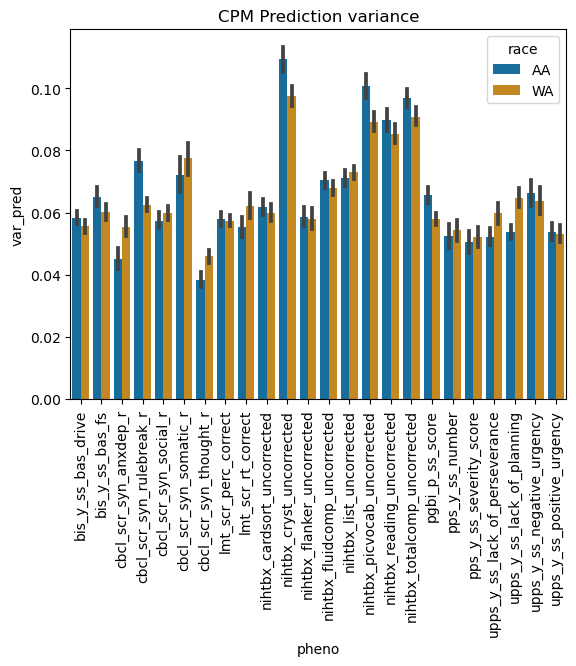

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data=df_results, x='pheno', y='var_pred', hue='race',
           palette=sns.color_palette('colorblind'),
           errorbar='ci')
plt.xticks(rotation=90)
plt.title('CPM Prediction variance')  # Add your desired title
plt.savefig('../output/pred_var_CPM.png')
plt.show()

### KRR Plots

#### Version with heldout clusters

In [ ]:
mats = df_merged['lowest_motion_connectomes']
mats = np.array(mats.tolist())

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


df_results = pd.DataFrame()  # initialize empty dataframe of results
for pheno in tqdm(beh_comb): # loop over all phenotypes
    print('**************************{:s}***********************************'.format(pheno))
    
    X = np.copy(mats)
    Y = np.array(df_merged[pheno])
    Y = Y.reshape(-1, 1)
#     Apply standard scaler to y
    y = scaler.fit_transform(Y)
    
    # initialize empty lists
    yp_all = np.zeros((len(y),))
    corr_vals = []
    var_true_b = []  # variance of true behavior of Black participants
    var_true_w = []  # variance of true behavior of White participants
    var_pred_b = []  # variance of predicted behavior of Black participants
    var_pred_w = []  # variance of predicted behavior of White participants
    site_cluster_combos = list( it.combinations( list(range(1, 11)) , 3))  # make (10 choose 3) combinations of site clusters

    for iter_idx, heldout_site_cluters in tqdm(enumerate(site_cluster_combos)):
         #### get training / test data ####
        print(f"Running Combination {iter_idx+1}")
        heldout_idx = np.where(df_merged.site_cluster.isin(heldout_site_cluters))[0]
        training_idx = np.setdiff1d(np.arange(X.shape[0]), heldout_idx)
        df_tmp = df_merged[df_merged.site_cluster.isin(heldout_site_cluters)].reset_index(drop=True)
        X_train = np.copy(X[training_idx, :])
        X_heldout = np.copy(X[heldout_idx, :])
        y_train = np.copy(y[training_idx])
        y_heldout = np.copy(y[heldout_idx])

        #### Model fitting ####
        # (Note: we did not perform any hyperparameter optimization as a first-pass)

        regr = KernelRidge(kernel='rbf')# kernel ridge regression to match Genon et al. paper
        

        regr.fit(X_train, y_train)
        
        # predict

        yp = regr.predict(X_heldout)
        
        # performance evaluation
        corr_vals.append(np.corrcoef(y_heldout, yp)[0, 1])
        
        #### Variance evaluation ####
        
        # add true and predicted values to temporary dataframe
        df_tmp['yp'] = yp
        df_tmp['y'] = np.array(df_tmp[pheno])
        # save this dataframe for each phenotype and iteration (group of held-out site clusters)
        if save_each_pred:
            df_tmp.to_csv(os.path.join(save_path, 
                                       'variance_prediction_results',
                                       '{:s}_iter_{:d}.csv'.format(pheno, iter_idx) ), index=False)
        
        # Group by race and get the variance in each race
        df_var_grouped = df_tmp.groupby(['Race'], as_index=False).agg({pheno:'var', 'yp':'var'})
        
        # store the variance results for true and predicted behaviors
        var_true_b.append(float(df_var_grouped.loc[df_var_grouped.Race=='Black', pheno]))
        var_true_w.append(float(df_var_grouped.loc[df_var_grouped.Race=='White', pheno]))        
        var_pred_b.append(float(df_var_grouped.loc[df_var_grouped.Race=='Black', 'yp']))
        var_pred_w.append(float(df_var_grouped.loc[df_var_grouped.Race=='White', 'yp']))
    
    # store in dataframe
    df_store = pd.DataFrame({'pheno':len(var_true_b)*2*[pheno],
#                             'cod':cod_vals_b+cod_vals_w,
#                       'r':corr_vals_b+corr_vals_w,
                        'var_true':var_true_b+var_true_w,
                           'var_pred':var_pred_b+var_pred_w,
                      'race':len(var_true_b)*['AA'] + len(var_true_b)*['WA']})
    df_results = pd.concat([df_results, df_store]).reset_index(drop=True)

# Save dataframe to .csv file
df_results.to_csv(os.path.join(save_path, 'pred_var_KRR.csv'), index=False)

In [3]:
# set load path
load_path = '../data/'


df_results = pd.read_csv(os.path.join(load_path, 'pred_var_KRR.csv'))
# df_results['pheno'] = df_results['pheno'].apply(lambda x: x.replace('HOLMES_', ''))
df_results = df_results.sort_values(by=['race', 'pheno']).reset_index(drop=True)
df_results

FileNotFoundError: [Errno 2] No such file or directory: '../data/pred_var_KRR.csv'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data=df_results, x='pheno', y='var_pred', hue='race',
           palette=sns.color_palette('colorblind'))
plt.xticks(rotation=90)
plt.title('KRR Prediction variance')  # Add your desired title
# plt.savefig('rfr_cpm_co.png')
plt.show()

#### Version with 5-fold

In [ ]:
import numpy as np
import pandas as pd
import itertools as it
import os
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

# Extract motion connectomes
mats = df_merged['lowest_motion_connectomes']
mats = np.array(mats.tolist())

scaler = StandardScaler()
df_results = pd.DataFrame()  # Initialize empty dataframe for results
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold Cross Validation

for pheno in tqdm(beh_comb):  # Loop over all phenotypes
    print(f'Processing phenotype: {pheno}')
    
    X = np.copy(mats)
    Y = np.array(df_merged[pheno]).reshape(-1, 1)
    Y = scaler.fit_transform(Y)  # Standardizing target variable
    
    # Initialize empty lists for performance and variance tracking
    corr_vals = []
    var_true_b, var_true_w = [], []  # Variance of true behavior for Black & White participants
    var_pred_b, var_pred_w = [], []  # Variance of predicted behavior for Black & White participants
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Running Fold {fold + 1}")
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        df_tmp = df_merged.iloc[test_idx].reset_index(drop=True)
        
        # Model fitting
        regr = KernelRidge(kernel='rbf')  # Kernel Ridge Regression
        regr.fit(X_train, y_train)
        
        # Predict
        yp = regr.predict(X_test)
        corr_vals.append(np.corrcoef(y_test.flatten(), yp.flatten())[0, 1])
        
        # Variance evaluation
        df_tmp['yp'] = yp.flatten()
        df_tmp['y'] = df_tmp[pheno]
        
        if save_each_pred:
            df_tmp.to_csv(os.path.join(save_path, 'variance_prediction_results', f'{pheno}_fold_{fold}.csv'), index=False)
        
        # Compute variance by race
        df_var_grouped = df_tmp.groupby(['Race'], as_index=False).agg({pheno: 'var', 'yp': 'var'})
        
        # Store variance results
        if 'Black' in df_var_grouped.Race.values:
            var_true_b.append(float(df_var_grouped.loc[df_var_grouped.Race == 'Black', pheno]))
            var_pred_b.append(float(df_var_grouped.loc[df_var_grouped.Race == 'Black', 'yp']))
        else:
            var_true_b.append(np.nan)
            var_pred_b.append(np.nan)
        
        if 'White' in df_var_grouped.Race.values:
            var_true_w.append(float(df_var_grouped.loc[df_var_grouped.Race == 'White', pheno]))
            var_pred_w.append(float(df_var_grouped.loc[df_var_grouped.Race == 'White', 'yp']))
        else:
            var_true_w.append(np.nan)
            var_pred_w.append(np.nan)
    
    # Store results in dataframe
    df_store = pd.DataFrame({
        'pheno': len(var_true_b) * 2 * [pheno],
        'var_true': var_true_b + var_true_w,
        'var_pred': var_pred_b + var_pred_w,
        'race': len(var_true_b) * ['AA'] + len(var_true_b) * ['WA']
    })
    
    df_results = pd.concat([df_results, df_store]).reset_index(drop=True)

# Save final results
df_results.to_csv(os.path.join(save_path, 'pred_var_KRR_5fold.csv'), index=False)

In [ ]:
# set load path
load_path = '../data/'


df_results = pd.read_csv(os.path.join(load_path, 'pred_var_KRR_5fold.csv'))
# df_results['pheno'] = df_results['pheno'].apply(lambda x: x.replace('HOLMES_', ''))
df_results = df_results.sort_values(by=['race', 'pheno']).reset_index(drop=True)
df_results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data=df_results, x='pheno', y='var_pred', hue='race',
           palette=sns.color_palette('colorblind'))
plt.xticks(rotation=90)
plt.title('KRR Prediction variance')  # Add your desired title
# plt.savefig('rfr_cpm_co.png')
plt.show()

### RFR Plot

In [ ]:
from sklearn.ensemble import RandomForestRegressor


df_results = pd.DataFrame()  # initialize empty dataframe of results
for pheno in tqdm(beh_comb): # loop over all phenotypes
    print('**************************{:s}***********************************'.format(pheno))
    
    X = np.copy(mats)
    Y = np.array(df_merged[pheno])
    Y = Y.reshape(-1, 1)
    #Apply standard scaler to y
    y = scaler.fit_transform(Y)
    y = y.flatten()

    # initialize empty lists
    yp_all = np.zeros((len(y),))
    corr_vals = []
    var_true_b = []  # variance of true behavior of Black participants
    var_true_w = []  # variance of true behavior of White participants
    var_pred_b = []  # variance of predicted behavior of Black participants
    var_pred_w = []  # variance of predicted behavior of White participants
    site_cluster_combos = list( it.combinations( list(range(1, 11)) , 3))  # make (10 choose 3) combinations of site clusters

    for iter_idx, heldout_site_cluters in tqdm(enumerate(site_cluster_combos)):
         #### get training / test data ####
        print(f"Running Combination {iter_idx+1}")
        heldout_idx = np.where(df_merged.site_cluster.isin(heldout_site_cluters))[0]
        training_idx = np.setdiff1d(np.arange(X.shape[0]), heldout_idx)
        df_tmp = df_merged[df_merged.site_cluster.isin(heldout_site_cluters)].reset_index(drop=True)
        X_train = np.copy(X[training_idx, :])
        X_heldout = np.copy(X[heldout_idx, :])
        y_train = np.copy(y[training_idx])
        y_heldout = np.copy(y[heldout_idx])

        #### Model fitting ####
        # (Note: we did not perform any hyperparameter optimization as a first-pass)

        regr = RandomForestRegressor(n_estimators=20, verbose=1, max_depth=10, n_jobs=-1, max_features='sqrt')
         # kernel ridge regression to match Genon et al. paper
        

        regr.fit(X_train, y_train)
        
        # predict

        yp = regr.predict(X_heldout)
        
        # performance evaluation
        corr_vals.append(np.corrcoef(y_heldout, yp)[0, 1])
        
        #### Variance evaluation ####
        
        # add true and predicted values to temporary dataframe
        df_tmp['yp'] = yp
        df_tmp['y'] = np.array(df_tmp[pheno])
        # save this dataframe for each phenotype and iteration (group of held-out site clusters)
        if save_each_pred:
            df_tmp.to_csv(os.path.join(save_path, 
                                       'variance_prediction_results',
                                       '{:s}_iter_{:d}.csv'.format(pheno, iter_idx) ), index=False)
        
        # Group by race and get the variance in each race
        df_var_grouped = df_tmp.groupby(['Race'], as_index=False).agg({pheno:'var', 'yp':'var'})
        
        # store the variance results for true and predicted behaviors
        var_true_b.append(float(df_var_grouped.loc[df_var_grouped.Race=='Black', pheno]))
        var_true_w.append(float(df_var_grouped.loc[df_var_grouped.Race=='White', pheno]))        
        var_pred_b.append(float(df_var_grouped.loc[df_var_grouped.Race=='Black', 'yp']))
        var_pred_w.append(float(df_var_grouped.loc[df_var_grouped.Race=='White', 'yp']))
    
    # store in dataframe
    df_store = pd.DataFrame({'pheno':len(var_true_b)*2*[pheno],
#                             'cod':cod_vals_b+cod_vals_w,
#                       'r':corr_vals_b+corr_vals_w,
                        'var_true':var_true_b+var_true_w,
                           'var_pred':var_pred_b+var_pred_w,
                      'race':len(var_true_b)*['AA'] + len(var_true_b)*['WA']})
    df_results = pd.concat([df_results, df_store]).reset_index(drop=True)

# Save dataframe to .csv file
df_results.to_csv(os.path.join(save_path, 'pred_var_KRR.csv'), index=False)

In [ ]:
# set load path
load_path = '../data/'


df_results = pd.read_csv(os.path.join(load_path, 'pred_var_KRR.csv'))
# df_results['pheno'] = df_results['pheno'].apply(lambda x: x.replace('HOLMES_', ''))
df_results = df_results.sort_values(by=['race', 'pheno']).reset_index(drop=True)
df_results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data=df_results, x='pheno', y='var_pred', hue='race',
           palette=sns.color_palette('colorblind'))
plt.xticks(rotation=90)
plt.title('RFR Prediction variance')  # Add your desired title
# plt.savefig('rfr_cpm_co.png')
plt.show()

In [ ]:
X.shape

### Neural Network

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import itertools as it

# Initialize scaler
scaler = StandardScaler()

# Initialize empty dataframe of results
df_results = pd.DataFrame()

for pheno in tqdm(beh_comb):  # loop over all phenotypes
    print(f"**************************{pheno}***********************************")

    X = np.copy(mats)
    Y = np.array(df_merged[pheno])
    Y = Y.reshape(-1, 1)

    # Apply standard scaler to y
    y = scaler.fit_transform(Y)
    y = y.flatten()

    # Initialize empty lists
    corr_vals = []
    var_true_b = []  # variance of true behavior of Black participants
    var_true_w = []  # variance of true behavior of White participants
    var_pred_b = []  # variance of predicted behavior of Black participants
    var_pred_w = []  # variance of predicted behavior of White participants
    site_cluster_combos = list(it.combinations(list(range(1, 11)), 3))  # make (10 choose 3) combinations of site clusters

    for iter_idx, heldout_site_clusters in tqdm(enumerate(site_cluster_combos)):
        print(f"Running Combination {iter_idx + 1}")

        # Get training / test data
        heldout_idx = np.where(df_merged.site_cluster.isin(heldout_site_clusters))[0]
        training_idx = np.setdiff1d(np.arange(X.shape[0]), heldout_idx)
        df_tmp = df_merged[df_merged.site_cluster.isin(heldout_site_clusters)].reset_index(drop=True)
        X_train = np.copy(X[training_idx, :])
        X_heldout = np.copy(X[heldout_idx, :])
        y_train = np.copy(y[training_idx])
        y_heldout = np.copy(y[heldout_idx])

        # Build neural network model
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='linear')
        ])

        # Compile model
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

        # Train model
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.1)

        # Predict
        yp = model.predict(X_heldout).flatten()

        # Performance evaluation
        corr_vals.append(np.corrcoef(y_heldout, yp)[0, 1])

        # Variance evaluation
        df_tmp['yp'] = yp
        df_tmp['y'] = np.array(df_tmp[pheno])

        # Group by race and get the variance in each race
        df_var_grouped = df_tmp.groupby(['Race'], as_index=False).agg({pheno: 'var', 'yp': 'var'})

        # Store the variance results for true and predicted behaviors
        var_true_b.append(float(df_var_grouped.loc[df_var_grouped.Race == 'Black', pheno]))
        var_true_w.append(float(df_var_grouped.loc[df_var_grouped.Race == 'White', pheno]))
        var_pred_b.append(float(df_var_grouped.loc[df_var_grouped.Race == 'Black', 'yp']))
        var_pred_w.append(float(df_var_grouped.loc[df_var_grouped.Race == 'White', 'yp']))

    # Store in dataframe
    df_store = pd.DataFrame({
        'pheno': len(var_true_b) * 2 * [pheno],
        'var_true': var_true_b + var_true_w,
        'var_pred': var_pred_b + var_pred_w,
        'race': len(var_true_b) * ['AA'] + len(var_true_b) * ['WA']
    })
    df_results = pd.concat([df_results, df_store]).reset_index(drop=True)

# Save dataframe to .csv file
df_results.to_csv(os.path.join(save_path, 'pred_var_NN.csv'), index=False)

In [ ]:
model.summary()

In [ ]:
X_train.dtype

In [ ]:
# set load path
load_path = '../data/'


df_results = pd.read_csv(os.path.join(load_path, 'pred_var_NN.csv'))
# df_results['pheno'] = df_results['pheno'].apply(lambda x: x.replace('HOLMES_', ''))
df_results = df_results.sort_values(by=['race', 'pheno']).reset_index(drop=True)
df_results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data=df_results, x='pheno', y='var_pred', hue='race',
           palette=sns.color_palette('colorblind'))
plt.xticks(rotation=90)
plt.title('NN Prediction variance')  # Add your desired title
# plt.savefig('rfr_cpm_co.png')
plt.show()